In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# read all the names in the dataset
words = open('names.txt',  'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [26]:
#building the vocabulary of characters and mapping them to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [27]:
#build datasets

import random
random.seed(42)
random.shuffle(words)

block_size = 3 # context length
vocab_size = 27 # number of chars in our char vocabulary (total possible outputs)

def build_dataset(words):
    #dataset prep
    X, Y = [], []  
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])       #80%
Xdev, Ydev = build_dataset(words[n1:n2])   #10%
Xte, Yte = build_dataset(words[n2:])       #10%

In [28]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters - trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # bufers - not trained with backprop but on the side with momentum to counter the batch norm on single input inference
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar+ self.eps) # normailise to unit variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [29]:
torch.manual_seed(42);

In [30]:
n_embed = 10 # the dimensionality of the embedding lookup table\
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embed))

layers = [
    Linear(n_embed*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), 
]


with torch.no_grad():
    #last layer make less confident
    layers[-1].weight *= 0.1
    # all othe rlayers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of params in total
for p in parameters:
    p.requires_grad = True

12097


In [31]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch contruct
    ix = torch.randint(1, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0] , -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3727
  10000/ 200000: 2.1458
  20000/ 200000: 2.2967
  30000/ 200000: 2.1526
  40000/ 200000: 2.0247
  50000/ 200000: 2.1767
  60000/ 200000: 2.2853
  70000/ 200000: 2.4672
  80000/ 200000: 2.2691
  90000/ 200000: 2.2537
 100000/ 200000: 2.1892
 110000/ 200000: 2.0261
 120000/ 200000: 2.0227
 130000/ 200000: 2.2644
 140000/ 200000: 2.0927
 150000/ 200000: 2.1780
 160000/ 200000: 2.2652
 170000/ 200000: 1.7924
 180000/ 200000: 2.0633
 190000/ 200000: 2.2720


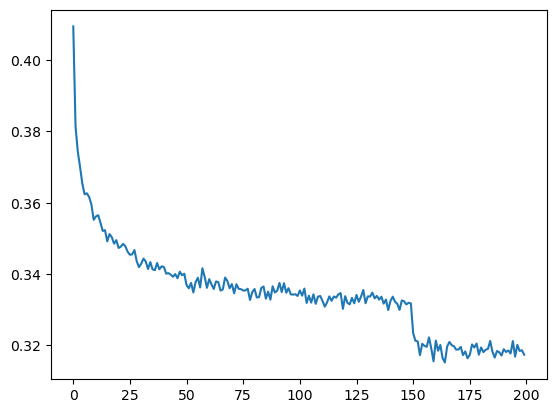

In [40]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) #takes avg loss of every 1000 iterations and plots that

In [33]:
for layer in layers:
    layer.training = False # to set the training flag in batchnorm layers as false

In [36]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]

    emb = C[x]
    x = emb.view(emb.shape[0], -1) #concat into N(total samples), block_size * n_embed
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.063005208969116
dev 2.107250213623047


In [38]:
for _ in range(20):
    out = []
    context = [0] * block_size # initializing with . . .
    while True:
        #forward pass
        emb = C[torch.tensor([context])] #(1, block_size, n_embed)
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = torch.softmax(logits, dim=1)
        #sample from the distribtion
        ix = torch.multinomial(probs, num_samples = 1).item()
        #shifting the context window
        context = context[1:] + [ix]
        out.append(ix)
        #if we encounted a special character
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) #decode and print the generated word

kei.
sakhan.
teona.
khyah.
zimilolan.
halle.
kyleah.
kenslewan.
roidia.
anya.
lav.
demin.
carric.
emirah.
rowian.
jatzle.
rorence.
noy.
haiveela.
nick.
